In [1]:
import pyod
import scipy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from matplotlib.pyplot import scatter
from pyod.models.ocsvm import OCSVM

In [2]:
contamination = 0.15

X_test, X_train, y_test, y_train = pyod.utils.data.generate_data(
                                      n_train = 300,
                                      n_test = 200,
                                      n_features = 3,
                                      contamination = contamination)

OCSVM_linear = OCSVM(kernel = "linear",contamination = contamination)
OCSVM_linear.fit(X_train)

y_test_pred_linear = OCSVM_linear.predict(X_test)
y_test_scores_linear = OCSVM_linear.decision_function(X_test)

bal_acc_linear = sklearn.metrics.balanced_accuracy_score(y_test, y_test_pred_linear)
roc_auc_linear = sklearn.metrics.roc_auc_score(y_test, y_test_scores_linear)

print ("Linear Kernel")
print ("___________________")
print (f"Balanced accuracy: {bal_acc_linear}")
print (f"ROC AUC: {roc_auc_linear}")

OCSVM_rbf = OCSVM(kernel = "rbf",contamination = contamination)
OCSVM_rbf.fit(X_train)

y_test_pred_rbf = OCSVM_rbf.predict(X_test)
y_test_scores_rbf = OCSVM_rbf.decision_function(X_test)

bal_acc_rbf = sklearn.metrics.balanced_accuracy_score(y_test, y_test_pred_rbf)
roc_auc_rbf = sklearn.metrics.roc_auc_score(y_test, y_test_scores_rbf)

print ()
print ("RBF Kernel")
print ("___________________")
print (f"Balanced accuracy: {bal_acc_rbf}")
print (f"ROC AUC: {roc_auc_rbf}")

y_train_pred_linear = OCSVM_linear.predict(X_train)
y_train_pred_rbf = OCSVM_rbf.predict(X_train)




Linear Kernel
___________________
Balanced accuracy: 1.0
ROC AUC: 1.0

RBF Kernel
___________________
Balanced accuracy: 1.0
ROC AUC: 1.0


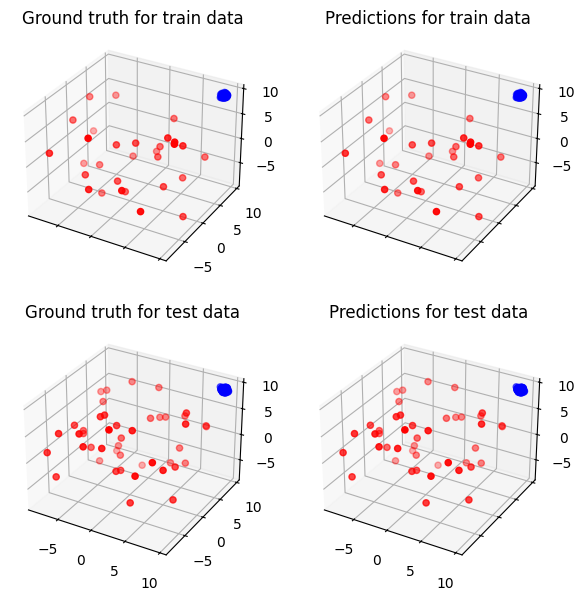

In [3]:
fig, plots = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True, subplot_kw={"projection":"3d"})

plots[0, 0].scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=['b' if x == 0 else 'r' for x in y_train])
plots[0, 0].set_title("Ground truth for train data")

plots[0, 1].scatter(X_train[:, 0], X_train[:, 1], X_train[: ,2], c=['b' if x == 0 else 'r' for x in y_train_pred_linear])
plots[0, 1].set_title("Predictions for train data")

plots[1, 0].scatter(X_test[: , 0], X_test[:, 1], X_test[:, 2], c=['b' if x == 0 else 'r' for x in y_test])
plots[1, 0].set_title("Ground truth for test data")

plots[1, 1].scatter(X_test[: , 0], X_test[:, 1], X_test[:, 2], c=['b' if x == 0 else 'r' for x in y_test_pred_linear])
plots[1, 1].set_title("Predictions for test data")


plt.show()

In [ ]:
#ex 2

In [23]:
import pandas as pd
from scipy.io import loadmat
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.metrics import balanced_accuracy_score, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [24]:
file_name = 'cardio 1.mat'

data = loadmat(file_name)
X = data['X']
y = data['y'].ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.4,
    random_state=42,
    stratify=y
)

# PyOD/ODDS format: 1 = Outlier, 0 = Inlier
# Sklearn OneClassSVM format: -1 = Outlier, 1 = Inlier
# Formula: y_sklearn = 1 - 2 * y_pyod
y_train = 1 - 2 * y_train
y_test  = 1 - 2 * y_test

n_outliers = np.sum(y_train == -1)
n_samples = len(y_train)
contamination_rate = n_outliers / n_samples

nu_values = [0.05, 0.1, contamination_rate, 0.2, 0.3]
# Ensure nu values are strictly between 0 and 1 and unique
nu_values = sorted(list(set([n for n in nu_values if 0 < n <= 1])))

param_grid = {
    'svm__kernel': ['rbf', 'sigmoid', 'poly', 'linear'],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'svm__nu': nu_values
}

In [25]:
# Pipeline with StandardScaler and OneClassSVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', OneClassSVM())
])

# We can use 'balanced_accuracy' directly now because y_train and predictions
# share the same format (-1 for outliers, 1 for inliers).
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n--- Best Parameters Found ---")
print(grid_search.best_params_)
print(f"Best CV Balanced Accuracy: {grid_search.best_score_:.4f}")

# Validate on the hold-out Test Set using the best estimator
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)

# Calculate Balanced Accuracy on Test Set
test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
print(f"\nTest Set Balanced Accuracy: {test_bal_acc:.4f}")

print("\n--- Final Evaluation on Test Set (60% split) ---")
# Note: Labels are now -1 (Outlier) and 1 (Inlier)
print(classification_report(y_test, y_test_pred, target_names=['Outlier (-1)', 'Inlier (1)']))

Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Best Parameters Found ---
{'svm__gamma': 0.001, 'svm__kernel': 'rbf', 'svm__nu': 0.3}
Best CV Balanced Accuracy: 0.8695

Test Set Balanced Accuracy: 0.8957

--- Final Evaluation on Test Set (60% split) ---
              precision    recall  f1-score   support

Outlier (-1)       0.37      0.97      0.53       106
  Inlier (1)       1.00      0.82      0.90       993

    accuracy                           0.83      1099
   macro avg       0.68      0.90      0.72      1099
weighted avg       0.94      0.83      0.86      1099



In [18]:
# ex 3

In [26]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from pyod.models.ocsvm import OCSVM
from pyod.models.deep_svdd import DeepSVDD

In [36]:
data = loadmat(file_name)
X = data['X']
y = data['y'].ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.5,
    random_state=42,
    stratify=y
)

# Normalize Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n_features = X_train.shape[1]

In [37]:
def evaluate_model(model, X_test, y_test, model_name):
  # Outlier scores (higher scores = anomaly detected)
  y_test_scores = model.decision_function(X_test)

  # Predict Labels
  y_test_pred = model.predict(X_test)

  # Calculate Metrics
  roc = roc_auc_score(y_test, y_test_scores)
  ba = balanced_accuracy_score(y_test, y_test_pred)

  return roc, ba

In [38]:
contamination = np.sum(y_train == 1) / len(y_train)

# OCSVM
ocsvm_model = OCSVM(kernel='rbf', contamination=contamination)
ocsvm_model.fit(X_train)
evaluate_model(ocsvm_model, X_test, y_test, 'OCSVM')

(np.float64(0.9362099253403602), np.float64(0.6962285902503293))

In [39]:
deep_svdd_default = DeepSVDD(
    n_features = n_features,
    contamination = contamination,
    epochs = 20,
    verbose = 0
)
deep_svdd_default.fit(X_train)
evaluate_model(deep_svdd_default, X_test, y_test, 'DeepSVDD Default')

Epoch 1/20, Loss: 22.72154462337494
Epoch 2/20, Loss: 22.874195098876953
Epoch 3/20, Loss: 22.883272349834442
Epoch 4/20, Loss: 22.85247266292572
Epoch 5/20, Loss: 22.89532119035721
Epoch 6/20, Loss: 22.77466595172882
Epoch 7/20, Loss: 22.863660275936127
Epoch 8/20, Loss: 22.891266763210297
Epoch 9/20, Loss: 22.811381697654724
Epoch 10/20, Loss: 22.895465195178986
Epoch 11/20, Loss: 22.827003091573715
Epoch 12/20, Loss: 22.75480079650879
Epoch 13/20, Loss: 22.844495058059692
Epoch 14/20, Loss: 22.90584897994995
Epoch 15/20, Loss: 22.773650765419006
Epoch 16/20, Loss: 22.813664734363556
Epoch 17/20, Loss: 22.86290866136551
Epoch 18/20, Loss: 22.936060935258865
Epoch 19/20, Loss: 22.774650394916534
Epoch 20/20, Loss: 22.851261377334595


(np.float64(0.8537823891084761), np.float64(0.6382026789635485))

In [40]:
# DeepSVDD - more architectures

# Define architectures
architectures = {
    "Shallow": [32, 16],
    "Deep": [64, 32, 16, 8],
    "Wide": [128, 64],
}

results = {}

for name, hidden_neurons in architectures.items():
  model = DeepSVDD(
      n_features = n_features,
      hidden_neurons = hidden_neurons,
      contamination = contamination,
      epochs = 20,
      verbose = 0
  )

  model.fit(X_train)
  roc, ba = evaluate_model(model, X_test, y_test, name)
  results[name] = {"ROC" : roc, "BA" : ba}

for name, metrics in results.items():
  print(f"{name} - ROC: {metrics['ROC']:.4f}, BA: {metrics['BA']:.4f}")

Epoch 1/20, Loss: 17.42871254682541
Epoch 2/20, Loss: 17.286867260932922
Epoch 3/20, Loss: 17.41798135638237
Epoch 4/20, Loss: 17.33051496744156
Epoch 5/20, Loss: 17.24767717719078
Epoch 6/20, Loss: 17.302945971488953
Epoch 7/20, Loss: 17.359010934829712
Epoch 8/20, Loss: 17.37958225607872
Epoch 9/20, Loss: 17.327430576086044
Epoch 10/20, Loss: 17.30876335501671
Epoch 11/20, Loss: 17.39617082476616
Epoch 12/20, Loss: 17.279719680547714
Epoch 13/20, Loss: 17.32026818394661
Epoch 14/20, Loss: 17.322589576244354
Epoch 15/20, Loss: 17.312897264957428
Epoch 16/20, Loss: 17.37067022919655
Epoch 17/20, Loss: 17.437766134738922
Epoch 18/20, Loss: 17.391165167093277
Epoch 19/20, Loss: 17.443904876708984
Epoch 20/20, Loss: 17.48872807621956
Epoch 1/20, Loss: 0.22157564386725426
Epoch 2/20, Loss: 0.233221217058599
Epoch 3/20, Loss: 0.23598313564434648
Epoch 4/20, Loss: 0.24720831727609038
Epoch 5/20, Loss: 0.23783546965569258
Epoch 6/20, Loss: 0.22325595142319798
Epoch 7/20, Loss: 0.2294460502453